# Recipes for raster data
various sources

<!--TABLE OF CONTENTS-->
- [Raster I/O and basic properties of raster data](#Raster-I/O-and-basic-properties-of-raster-data)
  - [Affine transformations](#Affine-transformations)
  - [plotting the data](#plotting-the-data)
  - [bands](#bands)
  - [saving the corrected raster data](#saving-the-corrected-raster-data)
    - [reading again](#reading-again)
  - [Transformations between different image coordinates and crs coordinates](#Transformations-between-different-image-coordinates-and-crs-coordinates)
    - [from image co-ordinates to crs co-ordinates](#from-image-co-ordinates-to-crs-co-ordinates)
  - [from crs co-ordinates to images co-ordinates](#from-crs-co-ordinates-to-images-co-ordinates)
- [Raster math](#Raster-math)
  - [reclassifying raster values](#reclassifying-raster-values)
  - [adding constants](#adding-constants)
- [Changing raster resolution](#Changing-raster-resolution)
  - [upsamling](#upsamling)
  - [downsampling](#downsampling)
- [Cropping raster data](#Cropping-raster-data)
- [Exract raster values to points](#Exract-raster-values-to-points)
- [Zonal Statistics](#Zonal-Statistics)

In [1]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
from IPython.display import Image
from rasterio.enums import Resampling
from rasterstats import zonal_stats

# Raster I/O and basic properties of raster data

In [2]:
suit = rasterio.open('./data/agrisuit.tif')

We can display a bunch of information about the data

In [3]:
suit.crs

CRS.from_epsg(4326)

In [4]:
suit.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

In [5]:
suit.transform

Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0)

## Affine transformations

Material summarizes discussion here:
https://medium.com/@mommermiscience/dealing-with-geospatial-raster-data-in-python-with-rasterio-775e5ba0c9f5

- raster data are arrays of pixels
- every pixel in the array is mapped to a geospatial location based on **affine transformation** and crs
- the affine transformation is stored in an `Affine` object
- defines how a change of 1 pixel in either direction (row / col) translates into crs coordinate changes using 6 parameters that are (in this order and all in the same units as the transformation's crs):
    - the change in $x$ as a function of the change in pixel column (+0.5 decimal degrees for +1 pixel)
    - change in $x$ as a function of the change in pixel row (0 decimal degrees for 1 pixel)
    - $x$-coordinate origin (-180 decimal degrees in this case)
    - change in $y$ as a function of the change in pixel column (0 decimal degrees for 1 pixel)
    - change in $y$ as a function of the change in pixel row (-0.5 decimal degrees for +1 pixel)
    - $y$-coordinate origin (90decimal degrees in this case)
- can consider transformation to consist of two parts:
    - a rotation matrix: in this case: $\begin{pmatrix} 0.5 & 0 \\ 0.0 & -0.5 \end{pmatrix}$ 
    - datasets's crs co-ordinate origin: in this case: $\begin{pmatrix} -180 \\ 90 \end{pmatrix}$
- see the cartoon (taken from the medium article) below:

<img src="affine.png" width=700 height=247 />

## plotting the data

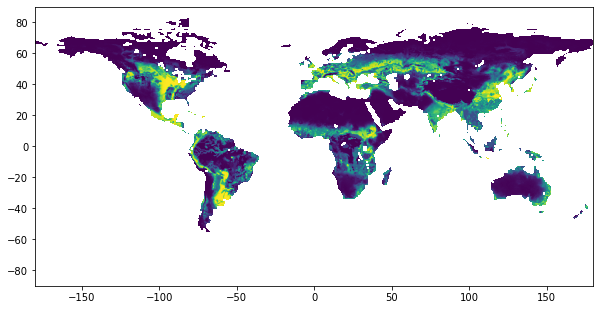

In [6]:
f, ax = plt.subplots(figsize=(10, 6))
show(suit, ax=ax)
plt.show()

## bands

In [7]:
suit.indexes

(1,)

This dataset has only one band. With satellite images, you will often have more than one band

We can get the array of data as follows

In [8]:
array = suit.read(1)

In [9]:
array

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)

Note that this is just a numpy array

In [10]:
type(array)

numpy.ndarray

But note tote that something is weird. Missing values seem to have been read as large negative values. 

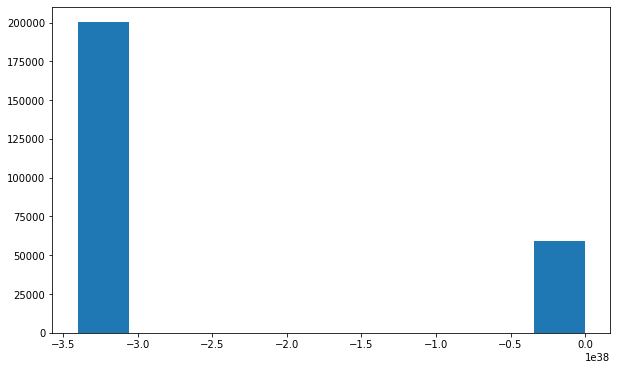

In [11]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(array.reshape(-1,1))
plt.show()

Fixing this:

In [12]:
array[array < 0] = np.nan

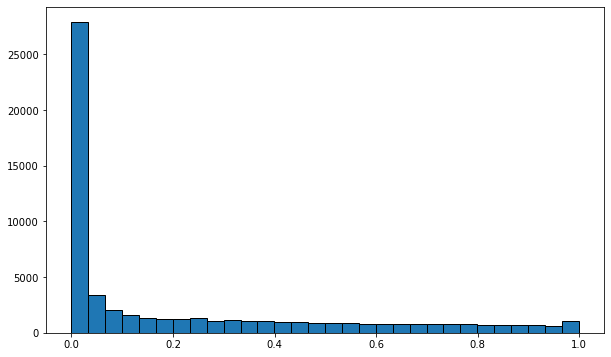

In [13]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(array.reshape(-1,1), bins=30, edgecolor='k')
plt.show()

## saving the corrected raster data

In [14]:
out_raster = rasterio.open('./data/agrisuit_corrected.tif',
                           'w',
                           driver='GTiff',
                           height=array.shape[0],
                           width=array.shape[1],
                           count=1,
                           dtype=array.dtype,
                           crs=suit.crs,
                           transform=suit.transform,
                          )
out_raster.write(array,1)
out_raster.close()

### reading again

In [15]:
suit = rasterio.open('./data/agrisuit_corrected.tif')

In [16]:
array = suit.read(1)

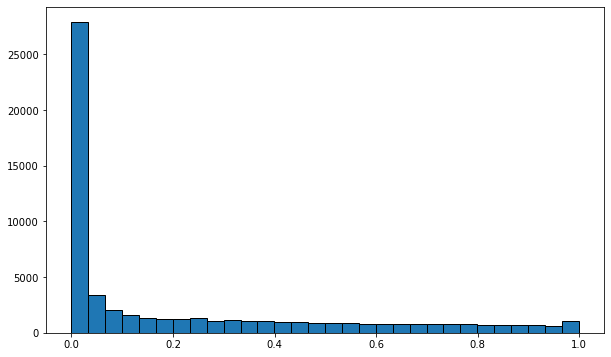

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(array.reshape(-1,1), bins=30, edgecolor='k')
plt.show()

In [18]:
array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

## Transformations between different image coordinates and crs coordinates
This is again taken from the medium article above

### from image co-ordinates to crs co-ordinates

In [19]:
row, col = 0, 0

In [20]:
x, y = suit.xy(row, col)

In [21]:
x, y

(-179.75, 89.75)

Note that this gives you the crs co-ordinates at the **center** of the pixel located in `row`, `column`. Another method is to just multiply (`row`, `column`) by the affine transformation:

In [22]:
x, y = suit.transform * (row, col)

In [23]:
x, y

(-180.0, 90.0)

This gives you a slightly different answer, since this gives you the answer relative to the origin co-ordinates of the transform.

## from crs co-ordinates to images co-ordinates

In [24]:
row, col = suit.index(-180, 90)

In [25]:
row, col

(0, 0)

In [26]:
suit.index(180, 90)

(0, 720)

In [27]:
suit.index(180, -90)

(360, 720)

In [28]:
array.shape

(360, 720)

This all makes sense, as we have a $0.5\times 0.5$ decimal degree raster (remember the rotation matrix?) with extent $[-180, -90, 180, 90]$.

# Raster math

Since the underlying array of raster values is just a `numpy` array, things couldnt be simpler:

## reclassifying raster values

In [29]:
binary_array = array.copy()
binary_array[binary_array >= 0.5] = 1
binary_array[binary_array < 0.5] = 0

<AxesSubplot:>

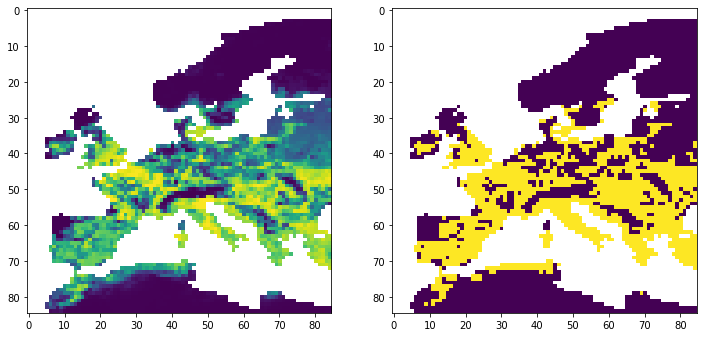

In [30]:
f, ax = plt.subplots(1,2, figsize=(12, 6))
show(array[35:120, 335:420], ax=ax[0])
show(binary_array[35:120, 335:420], ax=ax[1])

## adding constants

In [31]:
transformed_array = array.copy()
transformed_array[transformed_array >= 0.5] = transformed_array[transformed_array >= 0.5] + 2

<AxesSubplot:>

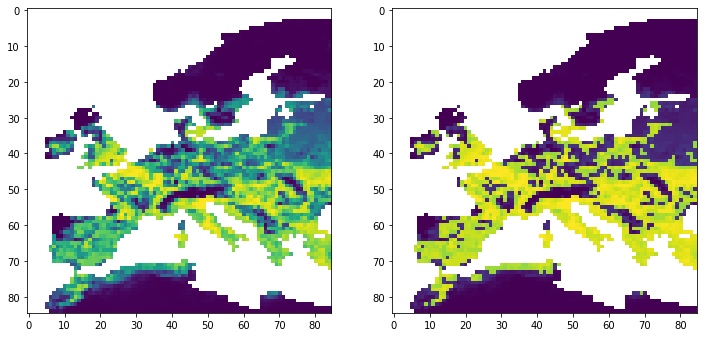

In [32]:
f, ax = plt.subplots(1,2, figsize=(12, 6))
show(array[35:120, 335:420], ax=ax[0])
show(transformed_array[35:120, 335:420], ax=ax[1])

# Changing raster resolution

## upsamling

In [33]:
up_sample_factor = 2

In [34]:
finer_array = suit.read(
            out_shape=(
            int(suit.height * up_sample_factor),
            int(suit.width * up_sample_factor)),
    resampling=Resampling.nearest
)
finer_array = finer_array.reshape((finer_array.shape[1], finer_array.shape[2]))

note there are different `resampling` algorithms possible. 
See here for details:
https://rasterio.readthedocs.io/en/latest/topics/resampling.html

Note also that when we define the shape for the re-sampled array, we are only giving `height` and `width`. In the `rasterio` example, they also use `dataset.count`. This is done for raster data that has more than one band and so has a "depth". Here we only have one band, and so are "Z-dimension" is zero. This is also why we are using the `reshape()` in the definition of the `finer_array`.

In [35]:
finer_array.shape

(720, 1440)

In [36]:
transform = suit.transform * suit.transform.scale(
    (suit.width / finer_array.shape[-1]),
    (suit.height / finer_array.shape[-2]),
)

In [37]:
out_raster = rasterio.open('./data/agrisuit_finer.tif',
                           'w',
                           driver='GTiff',
                           height=finer_array.shape[0],
                           width=finer_array.shape[1],
                           count=1,
                           dtype=finer_array.dtype,
                           crs=suit.crs,
                           transform=transform,
                          )
out_raster.write(array,1)
out_raster.close()

In [38]:
suit_finer = rasterio.open('./data/agrisuit_finer.tif')

In [39]:
suit_finer.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

In [40]:
suit_finer.crs

CRS.from_epsg(4326)

In [41]:
suit_finer.transform

Affine(0.25, 0.0, -180.0,
       0.0, -0.25, 90.0)

<AxesSubplot:>

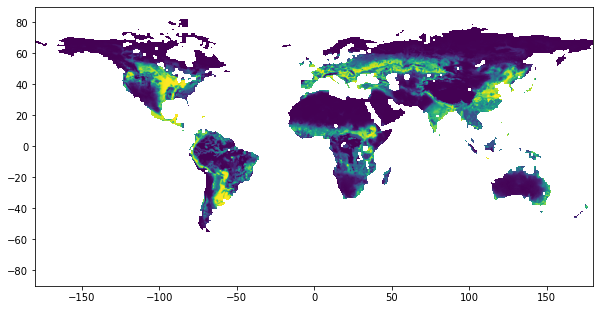

In [42]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
show(suit_finer, ax=ax)

## downsampling

In [43]:
up_sample_factor = 0.1

In [44]:
coarser_array = suit.read(
            out_shape=(
            int(suit.height * up_sample_factor),
            int(suit.width * up_sample_factor)),
    resampling=Resampling.nearest
)
coarser_array = coarser_array.reshape((coarser_array.shape[1], coarser_array.shape[2]))

In [45]:
transform = suit.transform * suit.transform.scale(
    (suit.width / coarser_array.shape[-1]),
    (suit.height / coarser_array.shape[-2]),
)

In [46]:
out_raster = rasterio.open('./data/agrisuit_coarser.tif',
                           'w',
                           driver='GTiff',
                           height=coarser_array.shape[0],
                           width=coarser_array.shape[1],
                           count=1,
                           dtype=coarser_array.dtype,
                           crs=suit.crs,
                           transform=transform,
                          )
out_raster.write(array,1)
out_raster.close()

In [47]:
suit_coarser = rasterio.open('./data/agrisuit_coarser.tif')

In [48]:
suit_coarser.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

In [49]:
suit_coarser.crs

CRS.from_epsg(4326)

In [50]:
suit_coarser.transform

Affine(5.0, 0.0, -180.0,
       0.0, -5.0, 90.0)

<AxesSubplot:>

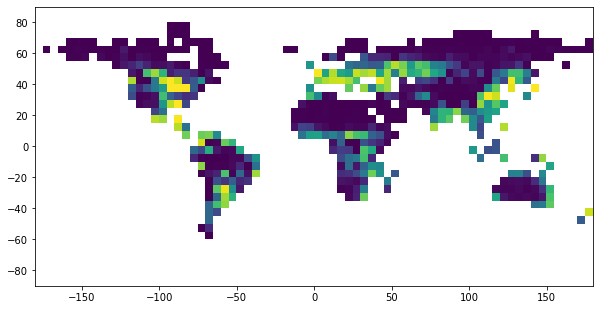

In [51]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
show(suit_coarser, ax=ax)

# Cropping raster data

In [52]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
argentina = world[world.name == 'Argentina'].copy()
argentina = gpd.GeoDataFrame({'geometry': argentina.geometry.values}, index=[0])
argentina = argentina.set_crs(world.crs)

<AxesSubplot:>

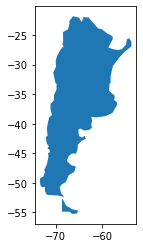

In [53]:
argentina.plot()

In [54]:
suit_arg_array, suit_arg_transform = mask(suit, shapes=argentina.geometry, crop=True)

<AxesSubplot:>

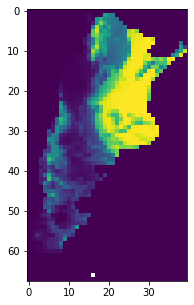

In [55]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
show(suit_arg_array, ax=ax)

In [56]:
suit_arg_array

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

Note something problematic has happened here
- the missing values were filled in with zeros, which are meaningful since they mean that agricultural suitability extends from 0 to 1. 
- we can fix that by specifying the `nodata` argument of `mask`

In [57]:
suit_arg_array, suit_arg_transform = mask(suit, shapes=argentina.geometry, crop=True, nodata=np.nan)

<AxesSubplot:>

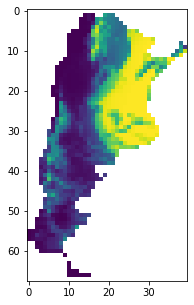

In [58]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
show(suit_arg_array, ax=ax)

to save the raster, we have to turn the array from 3D to a 2D raster (try it without that)

In [59]:
suit_arg_array.shape

(1, 68, 40)

In [60]:
suit_arg_array = suit_arg_array[0]

In [61]:
suit_arg_array.shape

(68, 40)

In [62]:
out_raster = rasterio.open('./data/agrisuit_argentina.tif',
                           'w',
                           driver='GTiff',
                           height=suit_arg_array.shape[0],
                           width=suit_arg_array.shape[1],
                           count=1,
                           dtype=suit_arg_array.dtype,
                           crs=suit.crs,
                           transform=suit_arg_transform,
                          )
out_raster.write(suit_arg_array,1)
out_raster.close()

reading again

In [63]:
suit_argentina = rasterio.open('./data/agrisuit_argentina.tif')

<AxesSubplot:>

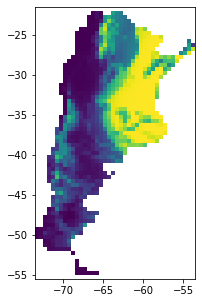

In [64]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
show(suit_argentina, ax=ax)

# Exract raster values to points

In [65]:
world = world.to_crs(epsg=6933)
centroids = gpd.GeoDataFrame({'geometry': world.geometry.centroid,
                              'country': world.name}).to_crs(epsg=4326)
world = world.to_crs(epsg=4326)

<AxesSubplot:>

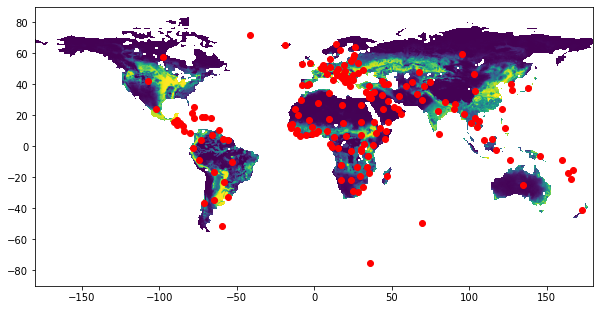

In [66]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
show(suit, ax=ax)
centroids.plot(ax=ax, color='r')

In [67]:
centroids['suit'] = np.nan
for i, point in enumerate(centroids.geometry):
    x, y = point.xy[0][0], point.xy[1][0]
    row, col = suit.index(x, y)
    centroids.loc[i, 'suit'] = suit.read(1)[row, col]

In [68]:
centroids

,geometry,country,suit
0,POINT (163.77641 -17.31278),Fiji,NaN
1,POINT (34.74767 -6.23773),Tanzania,0.127
2,POINT (-12.16218 24.24928),W. Sahara,0.005
3,POINT (-97.64486 57.62967),Canada,0.010
4,POINT (-107.54473 42.07501),United States of America,0.168
...,...,...,...
172,POINT (20.82827 44.21139),Serbia,0.710
173,POINT (19.28595 42.78634),Montenegro,0.744
174,POINT (20.89537 42.57743),Kosovo,0.296
175,POINT (-61.33042 10.42798),Trinidad and Tobago,0.000


In [69]:
che = world[world.name == 'Switzerland'].copy()
che = gpd.GeoDataFrame({'geometry': che.geometry.values}, index=[0])
che = che.set_crs(world.crs)

<AxesSubplot:>

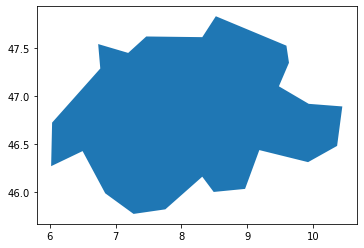

In [70]:
che.plot()

In [71]:
che_cent = centroids[centroids.country=='Switzerland'].reset_index(drop=True)

In [72]:
suit.crs

CRS.from_epsg(4326)

In [73]:
suit_che_array, suit_che_transform = mask(suit,
                                          shapes=che.geometry,
                                          crop=True, nodata=np.nan)

<AxesSubplot:>

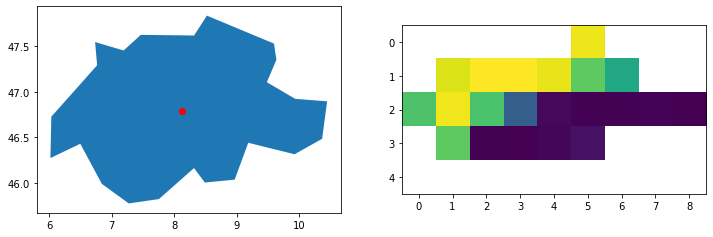

In [74]:
f, ax = plt.subplots(1,2, figsize=(12, 6))
che.plot(ax=ax[0])
che_cent.plot(ax=ax[0], color='r')
show(suit_che_array, ax=ax[1])

In [75]:
x, y = che_cent.geometry.values[0].xy
x, y

(array('d', [8.117176360463754]), array('d', [46.78605697395714]))

In [76]:
suit_che_array

array([[[  nan,   nan,   nan,   nan,   nan, 0.94 ,   nan,   nan,   nan],
        [  nan, 0.912, 0.961, 0.963, 0.932, 0.723, 0.577,   nan,   nan],
        [0.695, 0.941, 0.69 , 0.293, 0.019, 0.004, 0.005, 0.008, 0.   ],
        [  nan, 0.725, 0.006, 0.002, 0.015, 0.045,   nan,   nan,   nan],
        [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan]]],
      dtype=float32)

In [77]:
suit_che_transform * (4, 2)

(8.0, 47.0)

In [78]:
suit_che_array[0][2, 4]

0.019

In [79]:
che_cent

,geometry,country,suit
0,POINT (8.11718 46.78606),Switzerland,0.019


In [80]:
array = suit.read(1)
affine = suit.transform

# Zonal Statistics

In [81]:
zs = zonal_stats(world, array, affine=affine, stats=['mean'], nodata=np.nan, all_touched=True)    
world['mean_suit'] = [x['mean'] for x in zs]

In [82]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,mean_suit
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.501155
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0.005456
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.067059
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.320559
...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",0.661873
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0.584500
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0.247182
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0.329000
